In [1]:


random_dim=100

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers


In [2]:
# Keras 가 Tensorflow 를 벡엔드로 사용할 수 있도록 설정합니다.
os.environ["KERAS_BACKEND"] = "tensorflow"

# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

In [3]:
def optimizer():
  return Adam(lr=0.0002,beta_1=0.5)

def Generator(optimizer):
  generator=Sequential()
  generator.add(Dense(256,input_dim=random_dim,kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(784,activation='tanh'))
  generator.compile(loss='binary_crossentropy',optimizer=optimizer)
  return generator

def Discriminator(optimizer):
  discriminator=Sequential()
  discriminator.add(Dense(1024,input_dim=784,kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(1,activation='sigmoid'))
  discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)
  return discriminator

def G_D(generator,discriminator,optimizer):
  discriminator.trainable=False
  input=Input(shape=(random_dim),)

  x=generator(input)
  output=discriminator(x)
  GD=Model(inputs=input,outputs=output)
  GD.compile(loss='binary_crossentropy', optimizer=optimizer)
  return GD

In [4]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [5]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train=(x_train.astype(np.float32)-127.5)/127.5

x_train=x_train.reshape(60000,784)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 60000/60000 [1:02:42<00:00, 15.95it/s]


--------------- Epoch 2 ---------------


 60%|█████▉    | 35815/60000 [37:06<25:03, 16.08it/s]


KeyboardInterrupt: ignored

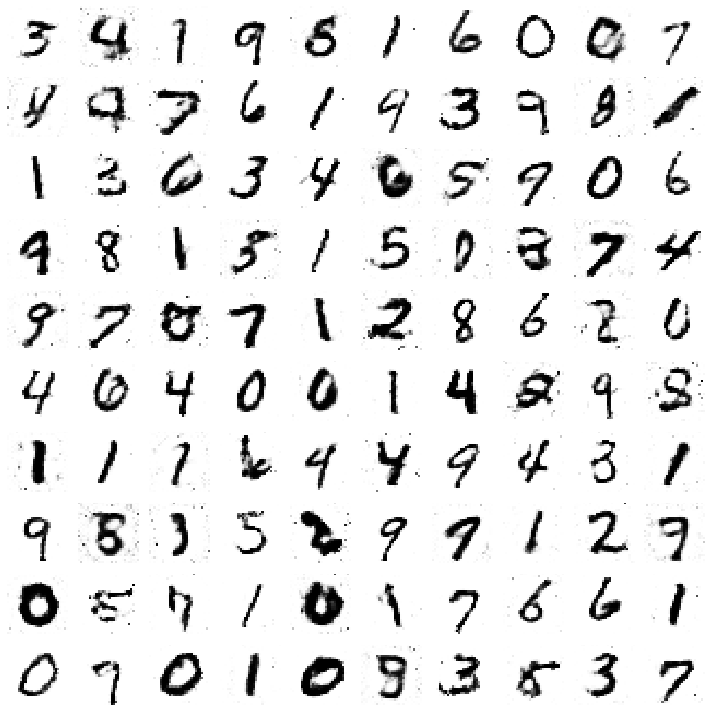

In [6]:
batch_count=x_train.shape[0]
batch_size=128

adam=optimizer()
generator=Generator(adam)
discriminator=Discriminator(adam)
Gan=G_D(generator,discriminator,adam)

for e in range(1,401):
  print('-'*15,'Epoch %d'%e,'-'*15 )
  for _ in tqdm(range(batch_count)):

    noise=np.random.normal(0,1,size=[batch_size,random_dim])

    image_batch=x_train[np.random.randint(0,x_train.shape[0],size=batch_size)]

    generated_images=generator.predict(noise)
    X=np.concatenate([image_batch,generated_images])

    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9

    discriminator.trainable=True
    discriminator.train_on_batch(X,y_dis)

    noise=np.random.normal(0,1,size=[batch_size,random_dim])
    y_gen=np.ones(batch_size)
    discriminator.trainable=False
    Gan.train_on_batch(noise,y_gen)

  if e == 1 or e % 20 == 0:
    plot_generated_images(e, generator)